In [ ]:
# in multilabel classification, images can't be fed in from folders - need a csv file with image -> class names mapping

# also, there are multiple metrics - fbeta, hamming loss, subset accuracy;
# based on many kaggle competitions, the most used performance metric is the fbeta score.

# newer versions of fast.ai use the skleran metric's to calculate the fbeta scores. 
# Ref: https://github.com/fastai/fastai/blob/master/fastai/metrics.py#L233

#### use of heatmaps to mark the region "focussed" by the model to draw inference

1. https://github.com/anurags25/FastAI-LIME ; 
2. https://github.com/marcotcr/lime/issues/374 ;
3. https://github.com/anurags25/FastAI-LIME/blob/master/LIME-Pets.ipynb ;
4. https://github.com/anurags25/FastAI-LIME/blob/master/lime_image.py ;
5. https://towardsdatascience.com/multi-label-classification-and-class-activation-map-on-fashion-mnist-1454f09f5925 (keras, separate maps for each class) ;

6. https://github.com/mingming97/multilabel-cam ;
7. https://glassboxmedicine.com/2020/05/29/grad-cam-visual-explanations-from-deep-networks/   says we should be able to use this for multiple classes ;
https://github.com/jacobgil/pytorch-grad-cam ;
https://github.com/yiskw713/SmoothGradCAMplusplus ;
https://www.kaggle.com/daisukelab/verifying-cnn-models-with-cam-and-etc-fast-ai * currently working ;


general reading:
https://towardsdatascience.com/anomaly-detection-in-images-777534980aeb  (keras) ;
https://www.pyimagesearch.com/2020/03/09/grad-cam-visualize-class-activation-maps-with-keras-tensorflow-and-deep-learning/ ;
https://forums.fast.ai/t/is-there-a-generic-heatmap-grad-cam-api/57218/2 ;
https://forums.fast.ai/t/using-class-activation-maps-cam-for-visualization/18864 ;
https://jacobgil.github.io/deeplearning/class-activation-maps ;
https://medium.com/@mrsalehi/a-review-of-different-interpretation-methods-in-deep-learning-part-1-saliency-map-cam-grad-cam-3a34476bc24d ;
https://medium.com/@mrsalehi/a-review-of-different-interpretation-methods-in-deep-learning-part-2-input-gradient-layerwise-e077609b6377 ;

In [ ]:
import pandas as pd
from fastai.vision import *
torch.cuda.empty_cache()

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
path = '/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj'
!nvidia-smi

In [ ]:
import os
df = pd.read_csv(os.path.join(path,'training.csv'))
df.head()

File name       Defect IDs
0  rolled-in_scale_173  Rolled-in scale
1  rolled-in_scale_218  Rolled-in scale
2  rolled-in_scale_205  Rolled-in scale
3  rolled-in_scale_193  Rolled-in scale
4  rolled-in_scale_212  Rolled-in scale

##Model building

In [ ]:
tfms = get_transforms(flip_vert=True, max_lighting=0.1, max_zoom=1.05, max_warp=0.)

In [ ]:
np.random.seed(42)
src = (ImageList.from_csv(path, 'training.csv', folder='Combined', suffix='.jpg')
       .split_by_rand_pct(0.2)
       .label_from_df(label_delim=','))

In [ ]:
data = (src.transform(tfms, size=128)
        .databunch().normalize(imagenet_stats))

In [ ]:
data.show_batch(rows=3, figsize=(12,9))

In [ ]:
arch = models.resnet50

In [ ]:
acc_02 = partial(accuracy_thresh, thresh=0.2)
f_score = partial(fbeta, thresh=0.2)
learn = cnn_learner(data, arch, metrics=[acc_02, f_score,error_rate]) ##https://docs.fast.ai/metrics#error_rate

Downloading: "https://download.pytorch.org/models/resnet50-19c8e357.pth" to /root/.cache/torch/hub/checkpoints/resnet50-19c8e357.pth


In [ ]:
data = (src.transform(tfms, size=256)
        .databunch().normalize(imagenet_stats))

learn.data = data
data.train_ds[0][0].shape

torch.Size([3, 256, 256])

In [ ]:
learn.freeze()

LR Finder is complete, type {learner_name}.recorder.plot() to see the graph.
Min numerical gradient: 1.58E-06
Min loss divided by 10: 1.32E-03


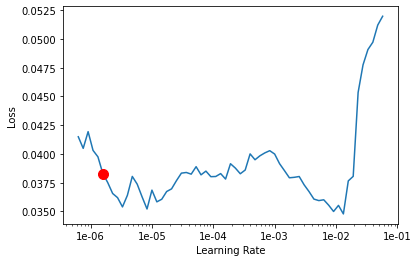

In [ ]:
learn.lr_find()
learn.recorder.plot(suggestion=True)

In [ ]:
lr=1e-2/2 #0.005

In [ ]:
learn.fit_one_cycle(5, slice(lr))

In [ ]:
learn.save('stage-1-256-rn50')

In [ ]:
learn.unfreeze()

In [ ]:
learn.fit_one_cycle(5, slice(1e-5, lr/5))

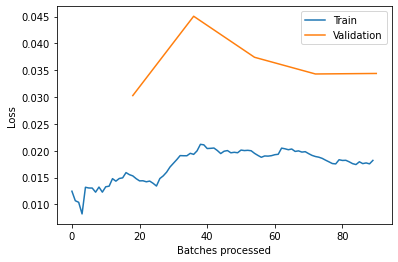

In [ ]:
learn.recorder.plot_losses()

## **Testing**

In [ ]:
learn.export()

In [ ]:
test = ImageList.from_folder(os.path.join(path,'test'))
len(test)

360

In [ ]:
learn = load_learner(path, test=test)
preds, _ = learn.get_preds(ds_type=DatasetType.Test)
#len(preds)
preds ## probability values after testing

tensor([[1.0000e+00, 2.3569e-04, 2.0127e-05, 3.0924e-05, 3.2323e-06, 8.3526e-05],
        [1.0000e+00, 7.8378e-04, 5.5343e-04, 6.7368e-05, 8.5713e-06, 1.1236e-04],
        [1.0000e+00, 1.0532e-04, 9.8845e-06, 5.6881e-05, 2.5404e-06, 3.4696e-05],
        ...,
        [9.1729e-06, 2.2072e-03, 3.8248e-06, 3.6351e-06, 2.7273e-06, 1.0000e+00],
        [2.4357e-05, 4.0894e-02, 7.8111e-05, 9.9730e-06, 6.3986e-06, 9.9473e-01],
        [8.4066e-05, 9.9496e-01, 1.2316e-03, 2.3157e-04, 3.9672e-05, 8.2503e-01]])

In [ ]:
thresh = 0.5
labelled_preds = [','.join([learn.data.classes[i] for i,p in enumerate(pred) if p > thresh]) for pred in preds]

In [ ]:
len(labelled_preds)

360

In [ ]:
fnames = [f.name[:-4] for f in learn.data.test_ds.items]

In [ ]:
df = pd.DataFrame({'image_name':fnames, 'tags':labelled_preds}, columns=['image_name', 'tags'])
df.to_csv('/content/drive/My Drive/Data/submission.csv', index=True)
df

image_name                 tags
0     crazing_101              Crazing
1      crazing_10              Crazing
2       crazing_1              Crazing
3     crazing_143              Crazing
4     crazing_102              Crazing
..            ...                  ...
355  scratches_48            Scratches
356  scratches_93  Inclusion,Scratches
357  scratches_68            Scratches
358  scratches_69            Scratches
359  scratches_96  Inclusion,Scratches

[360 rows x 2 columns]

In [ ]:
from sklearn.metrics import fbeta_score
import pandas as pd

df = pd.read_csv('/content/drive/My Drive/Data/submission_thresh_0.5.csv')
test_df = pd.read_csv('/content/drive/My Drive/Data/test.csv')

df.head()


image_name     tags
0    crazing_1  Crazing
1   crazing_10  Crazing
2  crazing_101  Crazing
3  crazing_102  Crazing
4  crazing_105  Crazing

In [ ]:
actual = test_df['Defect IDs'].tolist() ##list of actual and predicted values
pred = df['tags'].tolist()

In [ ]:
actual

In [ ]:
pred

In [ ]:
fbeta_sklearn = fbeta_score(test_new_df, pred_new, beta=2, average = 'weighted')
fbeta_sklearn

0.972605826219953

In [ ]:
fbeta_sklearn = fbeta_score(test_new_df, pred_new, beta=2, average = 'micro')
fbeta_sklearn

0.9728033472803348

In [ ]:
fbeta_sklearn = fbeta_score(test_new_df, pred_new, beta=2, average = 'macro')
fbeta_sklearn

0.9766746411483253

In [ ]:
fbeta_sklearn = fbeta_score(test_new_df, pred_new, beta=2, average = 'samples')
fbeta_sklearn

0.9830246913580247

##**Fbeta score using fastai**

In [ ]:
new_df = pd.concat([test_df.drop('Defect IDs', 1), test_df['Defect IDs'].str.get_dummies(sep=",")], 1)
new_df = new_df[new_df.columns[-6:new_df.columns.size]]

In [ ]:
new_df ##df of actual values (encoded)

Crazing  Inclusion  Patches  Pitted-surface  Rolled-in scale  Scratches
0          1          0        0               0                0          0
1          1          0        0               0                0          0
2          1          0        0               0                0          0
3          1          0        0               0                0          0
4          1          1        0               0                0          0
..       ...        ...      ...             ...              ...        ...
355        0          0        0               0                0          1
356        0          0        0               0                0          1
357        0          0        0               0                0          1
358        0          0        0               0                0          1
359        0          0        0               0                0          1

[360 rows x 6 columns]

In [ ]:
temp_df = pd.concat([df.drop('tags', 1), df['tags'].str.get_dummies(sep=",")], 1)
temp_df = temp_df[temp_df.columns[-6:temp_df.columns.size]]

In [ ]:
temp_df ##df of predicted values (encoded)

Crazing  Inclusion  Patches  Pitted-surface  Rolled-in scale  Scratches
0          1          0        0               0                0          0
1          1          0        0               0                0          0
2          1          0        0               0                0          0
3          1          0        0               0                0          0
4          1          0        0               0                0          0
..       ...        ...      ...             ...              ...        ...
355        0          0        0               0                0          1
356        0          0        0               0                0          1
357        0          0        0               0                0          1
358        0          1        0               0                0          1
359        0          1        0               0                0          1

[360 rows x 6 columns]

In [ ]:
Row_list =[] 
  
for i in range((new_df.shape[0])): 
    Row_list.append(list(new_df.iloc[i, :]))

len(Row_list)

360

In [ ]:
test_new_df = tensor(Row_list)

In [ ]:
test_new_df ##tensor of actual values

tensor([[1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 1]])

In [ ]:
fbeta(preds, test_new_df, thresh=0.5, sigmoid=False, beta=2)

tensor(0.9506)

In [ ]:
Row_list =[] 
  
for i in range((temp_df.shape[0])): 
    Row_list.append(list(temp_df.iloc[i, :]))

len(Row_list)

360

In [ ]:
pred_new = tensor(Row_list)
pred_new ## tensor of predict

tensor([[1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        [1, 0, 0, 0, 0, 0],
        ...,
        [0, 0, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 1],
        [0, 1, 0, 0, 0, 1]])

##Multilabel confusion matrix

In [ ]:
from sklearn.metrics import multilabel_confusion_matrix

labels = ['Crazing','Inclusion','Patches','Pitted-surface','Rolled-in scale','Scratches']
vis_arr = multilabel_confusion_matrix(test_new_df, pred_new) #labels=['Crazing','Inclusion','Patches','Pitted-surface','Rolled-in scale','Scratches'])

In [ ]:
temp_df.columns

Index(['Crazing', 'Inclusion', 'Patches', 'Pitted-surface', 'Rolled-in scale',
       'Scratches'],
      dtype='object')

In [ ]:
labels_name = ['Crazing','Inclusion','Patches','Pitted-surface','Rolled-in scale','Scratches']

In [ ]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns


def print_confusion_matrix(confusion_matrix, axes, class_label, class_names, fontsize=14):

    df_cm = pd.DataFrame(
        confusion_matrix, index=class_names, columns=class_names,
    )

    try:
        heatmap = sns.heatmap(df_cm, annot=True, fmt="d", cbar=False, ax=axes)
    except ValueError:
        raise ValueError("Confusion matrix values must be integers.")
    heatmap.yaxis.set_ticklabels(heatmap.yaxis.get_ticklabels(), rotation=0, ha='right', fontsize=fontsize)
    heatmap.xaxis.set_ticklabels(heatmap.xaxis.get_ticklabels(), rotation=45, ha='right', fontsize=fontsize)
    axes.set_xlabel('True label')
    axes.set_ylabel('Predicted label')
    axes.set_title("Confusion Matrix for the class - " + class_label)

In [ ]:
fig, ax = plt.subplots(2, 3, figsize=(12, 7))
for axes, cfs_matrix, label in zip(ax.flatten(), vis_arr, labels_name):
  print_confusion_matrix(cfs_matrix, axes, label, ["Y", "N"])
fig.tight_layout()
plt.show()  

## Other metrics

In [ ]:
from sklearn.metrics import accuracy_score
accuracy_score(test_new_df,pred_new) ##subset accuracy with one-hot encoded value

0.95

In [ ]:
from sklearn.metrics import hamming_loss
hamming_loss(test_new_df,pred_new) ##hamming loss

0.008796296296296297

In [ ]:
accuracy_score(actual,pred) ##subset acc with list labels

0.95

## GradCam

In [ ]:
path = '/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj'
learn = load_learner(path, 'export.pkl')
#learn

In [ ]:
import os
import numpy as np
import pandas as pd
from datetime import datetime
import matplotlib.pyplot as plt

import torch
import fastai
import time
from fastai.vision import *

from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

In [ ]:
# GradCAM
from fastai.vision import *
from fastai.callbacks.hooks import *
import scipy.ndimage

class GradCam():
    @classmethod
    def from_interp(cls,learn,interp,img_idx,ds_type=DatasetType.Valid,include_label=False):
        # produce heatmap and xb_grad for pred label (and actual label if include_label is True)
        if ds_type == DatasetType.Valid:
            ds = interp.data.valid_ds
        elif ds_type == DatasetType.Test:
            ds = interp.data.test_ds
            include_label=False
        else:
            return None
        
        x_img = ds.x[img_idx]
        xb,_ = interp.data.one_item(x_img)
        xb_img = Image(interp.data.denorm(xb)[0])
        probs = interp.preds[img_idx].numpy()

        pred_idx = interp.pred_class[img_idx].item() # get class idx of img prediction label
        hmap_pred,xb_grad_pred = get_grad_heatmap(learn,xb,pred_idx,size=xb_img.shape[-1])
        prob_pred = probs[pred_idx]
        
        actual_args=None
        if include_label:
            actual_idx = ds.y.items[img_idx] # get class idx of img actual label
            if actual_idx!=pred_idx:
                hmap_actual,xb_grad_actual = get_grad_heatmap(learn,xb,actual_idx,size=xb_img.shape[-1])
                prob_actual = probs[actual_idx]
                actual_args=[interp.data.classes[actual_idx],prob_actual,hmap_actual,xb_grad_actual]
        
        return cls(xb_img,interp.data.classes[pred_idx],prob_pred,hmap_pred,xb_grad_pred,actual_args)
    
    @classmethod
    def from_one_img(cls,learn,x_img,label1=None,label2=None):
        '''
        learn: fastai's Learner
        x_img: fastai.vision.image.Image
        label1: generate heatmap according to this label. If None, this wil be the label with highest probability from the model
        label2: generate additional heatmap according to this label
        '''
        pred_class,pred_idx,probs = learn.predict(x_img)
        label_t= str(pred_class) if not label1 else label1
        if ';' in label_t:
          label_list = label_t.split(";")
          label1 = label_list[0]
          label2 = label_list[1]
        print('Pred Class:',pred_class)
        print('Pred idx:',pred_idx)
        print('Label 1 :',label1)
        
        
        xb,_ = learn.data.one_item(x_img)
        xb_img = Image(learn.data.denorm(xb)[0])
        probs = probs.numpy()
        print('Probs:',probs)

        label1_idx = learn.data.classes.index(label1)
        hmap1,xb_grad1 = get_grad_heatmap(learn,xb,label1_idx,size=xb_img.shape[-1])
        prob1 = probs[label1_idx]
        print('Label 1 idx:',label1_idx)
        print('Label 1 prob:',prob1)
        
        label2_args = None
        if label2:
            print('We got to label 2')
            label2_idx = learn.data.classes.index(label2)
            hmap2,xb_grad2 = get_grad_heatmap(learn,xb,label2_idx,size=xb_img.shape[-1])
            prob2 = probs[label2_idx]
            print('Label 2 prob:',prob2)
            label2_args = [label2,prob2,hmap2,xb_grad2]
            
        return cls(xb_img,label1,prob1,hmap1,xb_grad1,label2_args)
    
    def __init__(self,xb_img,label1,prob1,hmap1,xb_grad1,label2_args=None): 
        self.xb_img=xb_img
        self.label1,self.prob1,self.hmap1,self.xb_grad1 = label1,prob1,hmap1,xb_grad1
        if label2_args:
            self.label2,self.prob2,self.hmap2,self.xb_grad2 = label2_args

            
    def plot(self,plot_hm=True,plot_gbp=True):
        save_path = '/content/drive/My Drive/Data/gradcam_results'
        file_name = 'img.png'
        if not plot_hm and not plot_gbp:
            plot_hm=True
        cols = 5 if hasattr(self, 'label2') else 3
        if not plot_gbp or not plot_hm:
            cols-= 2 if hasattr(self, 'label2') else 1

        fig,row_axes = plt.subplots(1,cols,figsize=(cols*5,5))  
        col=0
        size=self.xb_img.shape[-1]
        self.xb_img.show(row_axes[col]);col+=1
        
        label1_title = f'1.{self.label1} {self.prob1:.3f}'
        if plot_hm:
            show_heatmap(self.hmap1,self.xb_img,size,row_axes[col])
            row_axes[col].set_title(label1_title);col+=1
        if plot_gbp:
            row_axes[col].imshow(self.xb_grad1)
            row_axes[col].set_axis_off()
            row_axes[col].set_title(label1_title);col+=1
        
        if hasattr(self, 'label2'):
            label2_title = f'2.{self.label2} {self.prob2:.3f}'
            if plot_hm:
                show_heatmap(self.hmap2,self.xb_img,size,row_axes[col])
                row_axes[col].set_title(label2_title);col+=1
            if plot_gbp:
                row_axes[col].imshow(self.xb_grad2)
                row_axes[col].set_axis_off()
                row_axes[col].set_title(label2_title)
        # plt.tight_layout()
        fig.subplots_adjust(wspace=0, hspace=0)
        #fig.set_canvas(plt.gcf().canvas)
        #fig.save(os.path.join(save_path,filename))
        return fig

def minmax_norm(x):
    return (x - np.min(x))/(np.max(x) - np.min(x))
def scaleup(x,size):
    scale_mult=size/x.shape[0]
    upsampled = scipy.ndimage.zoom(x, scale_mult)
    return upsampled

# hook for Gradcam
def hooked_backward(m,xb,target_layer,clas):
    with hook_output(target_layer) as hook_a: #hook at last layer of group 0's output (after bn, size 512x7x7 if resnet34)
        with hook_output(target_layer, grad=True) as hook_g: # gradient w.r.t to the target_layer
            preds = m(xb)
            preds[0,int(clas)].backward() # same as onehot backprop
    return hook_a,hook_g

def clamp_gradients_hook(module, grad_in, grad_out):
    for grad in grad_in:
        torch.clamp_(grad, min=0.0)
        
# hook for guided backprop
def hooked_ReLU(m,xb,clas):
    relu_modules = [module[1] for module in m.named_modules() if str(module[1]) == "ReLU(inplace)"]
    with callbacks.Hooks(relu_modules, clamp_gradients_hook, is_forward=False) as _:
        preds = m(xb)
        preds[0,int(clas)].backward()
        
def guided_backprop(learn,xb,y):
    xb = xb.cuda()
    m = learn.model.eval();
    xb.requires_grad_();
    if not xb.grad is None:
        xb.grad.zero_(); 
    hooked_ReLU(m,xb,y);
    return xb.grad[0].cpu().numpy()

def show_heatmap(hm,xb_im,size,ax=None):
    if ax is None:
        _,ax = plt.subplots()
    xb_im.show(ax)
    ax.imshow(hm, alpha=0.3, extent=(0,size,size,0),
              interpolation='bilinear',cmap='jet');

def get_grad_heatmap(learn,xb,y,size):
    '''
    Main function to get hmap for heatmap and xb_grad for guided backprop
    '''
    xb = xb.cuda()
    m = learn.model.eval();
    target_layer = m[0][-1][-1] # last layer of group 0
    hook_a,hook_g = hooked_backward(m,xb,target_layer,y)
    
    target_act= hook_a.stored[0].cpu().numpy()
    target_grad = hook_g.stored[0][0].cpu().numpy()
    
    mean_grad = target_grad.mean(1).mean(1)
#     hmap = (target_act*mean_grad[...,None,None]).mean(0)
    hmap = (target_act*mean_grad[...,None,None]).sum(0)
    hmap = np.where(hmap >= 0, hmap, 0)
    
    xb_grad = guided_backprop(learn,xb,y) # (3,224,224)        
    #minmax norm the grad
    xb_grad = minmax_norm(xb_grad)
    hmap_scaleup = minmax_norm(scaleup(hmap,size)) # (224,224)
    
    # multiply xb_grad and hmap_scaleup and switch axis
    xb_grad = np.einsum('ijk, jk->jki',xb_grad, hmap_scaleup) #(224,224,3)
    
    return hmap,xb_grad

In [ ]:
test = ImageList.from_folder(os.path.join(path,'test'))
print(test.items)
len(test)

[PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/test/crazing_101.jpg')
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/test/crazing_10.jpg')
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/test/crazing_1.jpg')
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/test/crazing_143.jpg') ...
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/test/scratches_93.jpg')
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/test/scratches_68.jpg')
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/test/scratches_69.jpg')
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/test/scratches_96.jpg')]


360

In [ ]:
def file_name(i):
  save_path = '/content/drive/My Drive/Data/gradcam_results'
  file_name = str(test.items[i]).split('/')[-1]
  print(file_name)
  img = test[i]
  gcam = GradCam.from_one_img(learn,img)
  fig = gcam.plot()
  #fig.savefig(os.path.join(save_path,file_name))
  #return fig
  #print(type(fig))
  #return fig

crazing_143.jpg
Pred Class: Crazing
Pred idx: tensor([1., 0., 0., 0., 0., 0.])
Label 1 : Crazing
Probs: [1.000000e+00 1.502817e-03 3.525290e-04 3.973832e-05 6.178059e-06 7.332976e-05]
Label 1 idx: 0
Label 1 prob: 1.0


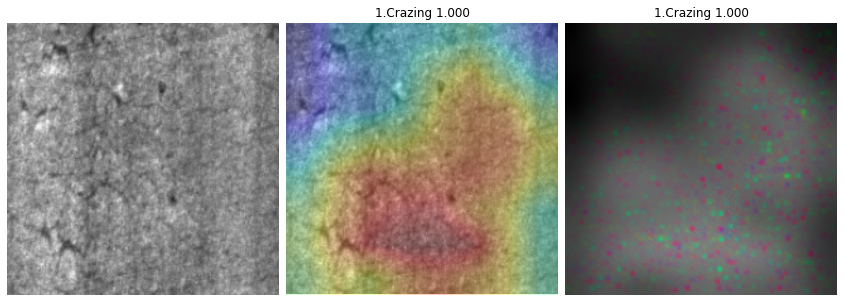

In [ ]:
file_name(3)

scratches_96.jpg
Pred Class: Inclusion;Scratches
Pred idx: tensor([0., 1., 0., 0., 0., 1.])
Label 1 : Inclusion
Probs: [8.406600e-05 9.949571e-01 1.231612e-03 2.315705e-04 3.967244e-05 8.250272e-01]
Label 1 idx: 1
Label 1 prob: 0.99495715
We got to label 2
Label 2 prob: 0.8250272


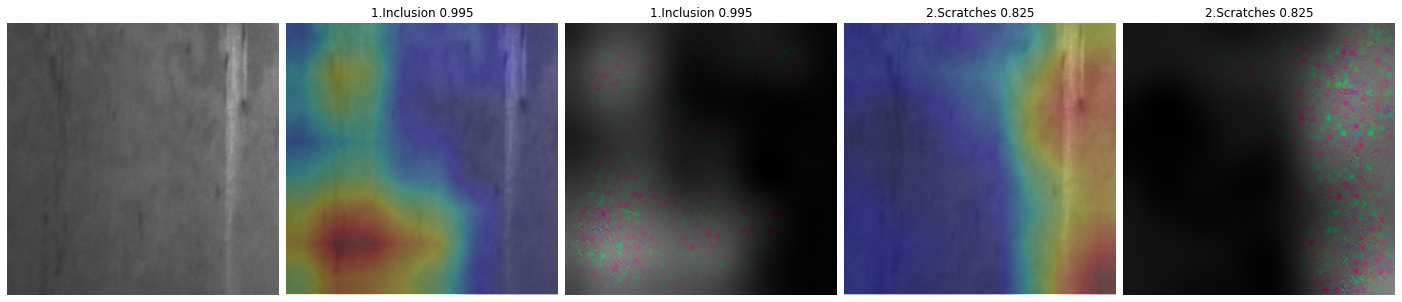

In [ ]:
file_name(359)

## ShowCAM

In [ ]:
path = '/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/models'
learn.load(os.path.join(path, 'stage-1-256-rn50'))

Learner(data=ImageDataBunch;

Train: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: /content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj;

Valid: LabelList (0 items)
x: ImageList

y: MultiCategoryList

Path: /content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj;

Test: None, model=Sequential(
  (0): Sequential(
    (0): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (2): ReLU(inplace=True)
    (3): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (4): Sequential(
      (0): Bottleneck(
        (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
        (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
        (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
        (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.

Traceback (most recent call last):
  File "/usr/lib/python3.6/multiprocessing/queues.py", line 230, in _feed
    close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 177, in close
    self._close()
  File "/usr/lib/python3.6/multiprocessing/connection.py", line 361, in _close
    _close(self._handle)
OSError: [Errno 9] Bad file descriptor


In [ ]:
import sys
import os
os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"   
os.environ["CUDA_VISIBLE_DEVICES"]="6"
import glob
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import skimage.transform as skt
from sklearn.metrics import confusion_matrix
from fastai.conv_learner import *
from fastai.model import *
from fastai.plots import *
import numpy as np

def show_CAM(model, images, classes):
    # Make the prediction on the batch
    log_prob = model(to_gpu(V(images)))
    # Denormalize the input of the batch
    x1 = data.val_ds.denorm(images)
    f = plt.figure(figsize=(16,8))
    rows=2
    for idx in range(len(x1)):
        # Get the activation of one image
        fts = sf[0].features[idx]
        prob = np.exp(to_np(log_prob))
        preds = np.argmax(prob[idx])
        fts_np = to_np(fts)
        f2=np.dot(np.rollaxis(fts_np,0,3), prob[idx])
        f2-=f2.min()
        f2/=f2.max()
        f2
        sp = f.add_subplot(rows, len(x1)//rows, idx+1)
        sp.axis('Off')
        sp.set_title(classes[preds], fontsize=12)
        plt.imshow(x1[idx])
        plt.imshow(scipy.misc.imresize(f2, x1[idx].shape), alpha=0.5, cmap='jet');
        #plt.imshow(skt.resize(f2, x1[idx].shape), alpha=0.5, cmap='hot');
    plt.show();

ModuleNotFoundError: ignored

In [ ]:
labels = ['Crazing','Inclusion','Patches','Pitted-surface','Rolled-in scale','Scratches']

In [ ]:
test = ImageList.from_folder(os.path.join(path,'gradcam'))
print(test.items)
len(test)

[PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/gradcam/crazing_1.jpg')
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/gradcam/crazing_10.jpg')
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/gradcam/crazing_101.jpg')
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/gradcam/crazing_102.jpg') ...
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/gradcam/scratches_85.jpg')
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/gradcam/scratches_86.jpg')
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/gradcam/scratches_93.jpg')
 PosixPath('/content/drive/My Drive/VQI/darknet/build/darknet/x64/data/obj/gradcam/scratches_96.jpg')]


337

In [ ]:
for i in range(4):
    show_CAM(learn, test, labels)

NameError: ignored

## GradCAM with interp

In [ ]:
interp = ClassificationInterpretation.from_learner(learn)

In [ ]:
from fastai.callbacks.hooks import *
import random
from random import randint
import cv2

# hook into forward pass
def hooked_backward(m, oneBatch, cat):
    # we hook into the convolutional part = m[0] of the model
    with hook_output(m[0]) as hook_a: 
        with hook_output(m[0], grad=True) as hook_g:
            preds = m(oneBatch)
            preds[0,int(cat)].backward()
    return hook_a,hook_g

# We can create a utility function for getting a validation image with an activation map
def getHeatmap(val_index):
    """Returns the validation set image and the activation map"""
    # this gets the model
    m = learn.model.eval()
    tensorImg,cl = data.valid_ds[val_index]
    # create a batch from the one image
    oneBatch,_ = data.one_item(tensorImg)
    oneBatch_im = vision.Image(data.denorm(oneBatch)[0])
    # convert batch tensor image to grayscale image with opencv
    cvIm = cv2.cvtColor(image2np(oneBatch_im.data), cv2.COLOR_RGB2GRAY)
    # attach hooks
    hook_a,hook_g = hooked_backward(m, oneBatch, cl)
    # get convolutional activations and average from channels
    acts = hook_a.stored[0].cpu()
    #avg_acts = acts.mean(0)

    # Grad-CAM
    grad = hook_g.stored[0][0].cpu()
    grad_chan = grad.mean(1).mean(1)
    grad.shape,grad_chan.shape
    mult = (acts*grad_chan[...,None,None]).mean(0)
    return mult, cvIm
  

# Then, modify our plotting func a bit
def plot_heatmap_overview(interp:ClassificationInterpretation, classes=['Negative','Tumor']):
    # top losses will return all validation losses and indexes sorted by the largest first
    tl_val,tl_idx = interp.top_losses()
    #classes = interp.data.classes
    fig, ax = plt.subplots(3,4, figsize=(16,12))
    fig.suptitle('Grad-CAM\nPredicted / Actual / Loss / Probability',fontsize=20)
    # Random
    for i in range(4):
        random_index = randint(0,len(tl_idx))
        idx = tl_idx[random_index]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[0,i].imshow(im)
        ax[0,i].imshow(im, cmap=plt.cm.gray)
        ax[0,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[0,i].set_xticks([])
        ax[0,i].set_yticks([])
        ax[0,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[0,0].set_ylabel('Random samples', fontsize=16, rotation=0, labelpad=80)
    # Most incorrect or top losses
    for i in range(4):
        idx = tl_idx[i]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[1,i].imshow(im)
        ax[1,i].imshow(im, cmap=plt.cm.gray)
        ax[1,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[1,i].set_xticks([])
        ax[1,i].set_yticks([])
        ax[1,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[1,0].set_ylabel('Most incorrect\nsamples', fontsize=16, rotation=0, labelpad=80)
    # Most correct or least losses
    for i in range(4):
        idx = tl_idx[len(tl_idx) - i - 1]
        act, im = getHeatmap(idx)
        H,W = im.shape
        _,cl = interp.data.dl(DatasetType.Valid).dataset[idx]
        cl = int(cl)
        ax[2,i].imshow(im)
        ax[2,i].imshow(im, cmap=plt.cm.gray)
        ax[2,i].imshow(act, alpha=0.5, extent=(0,H,W,0),
              interpolation='bilinear', cmap='inferno')
        ax[2,i].set_xticks([])
        ax[2,i].set_yticks([])
        ax[2,i].set_title(f'{classes[interp.pred_class[idx]]} / {classes[cl]} / {interp.losses[idx]:.2f} / {interp.probs[idx][cl]:.2f}')
    ax[2,0].set_ylabel('Most correct\nsamples', fontsize=16, rotation=0, labelpad=80)

In [ ]:
plot_heatmap_overview(interp, ['Crazing','Inclusion','Patches','Pitted-surface','Rolled-in scale','Scratches'])

# this gives errors

## CNN with CAM


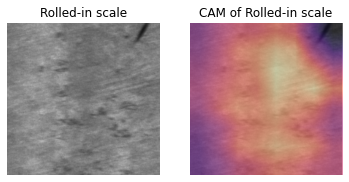

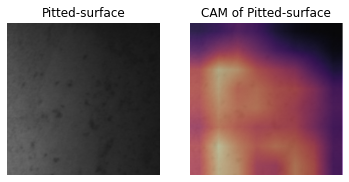

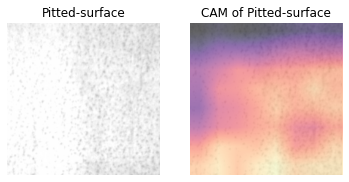

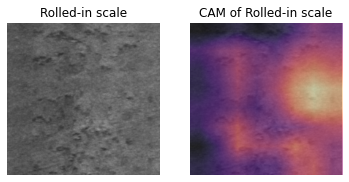

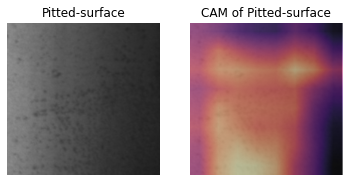

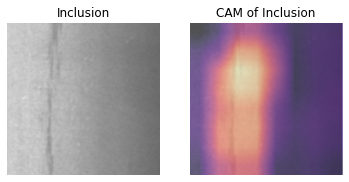

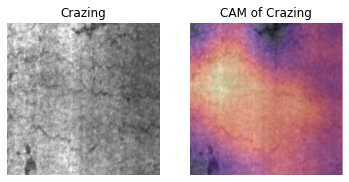

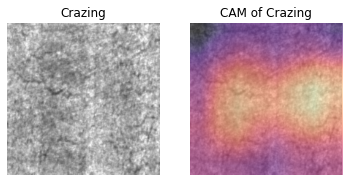

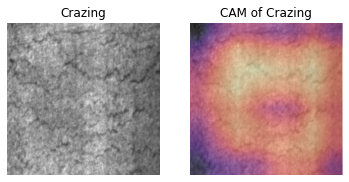

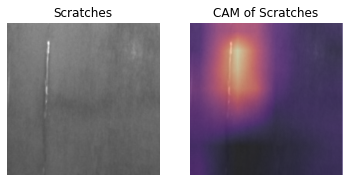

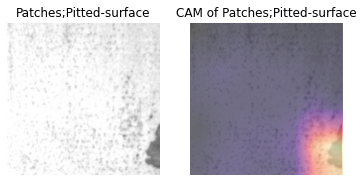

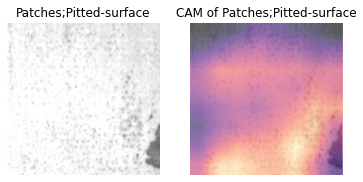

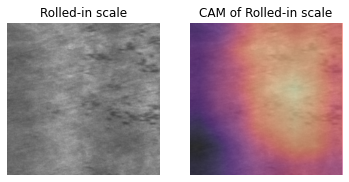

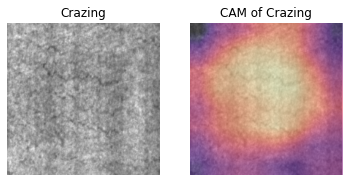

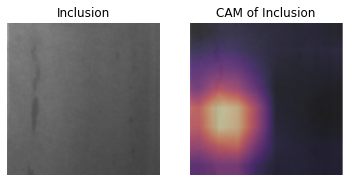

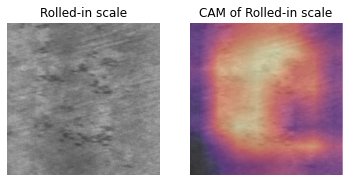

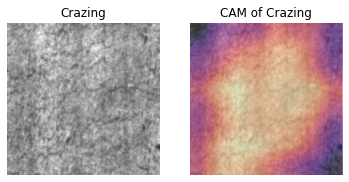

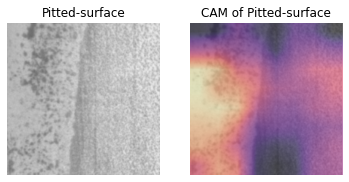

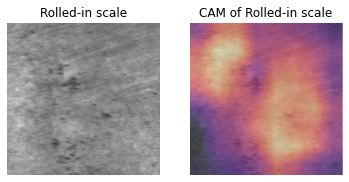

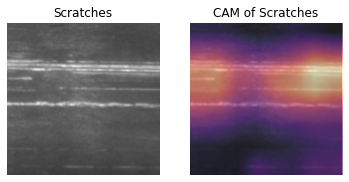

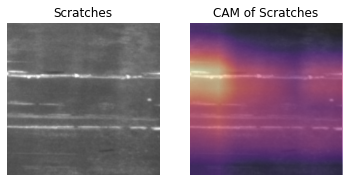

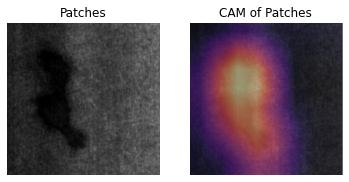

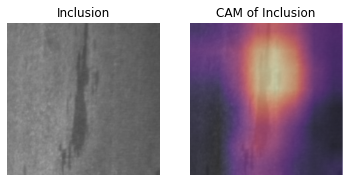

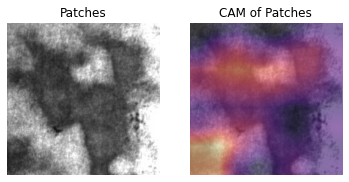

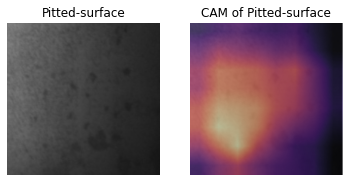

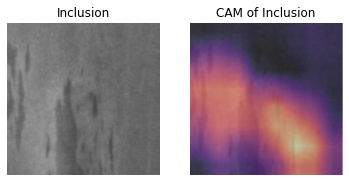

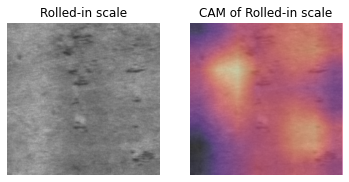

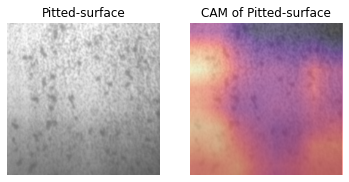

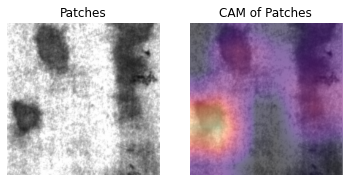

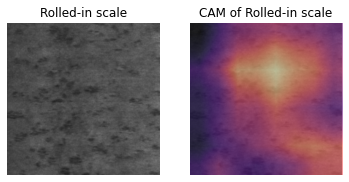

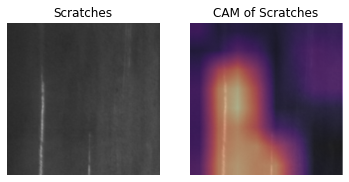

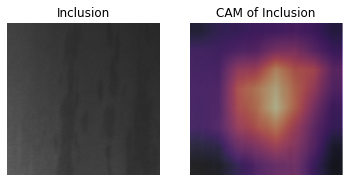

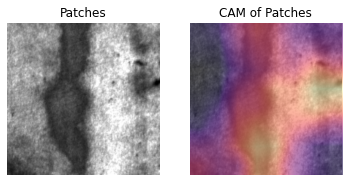

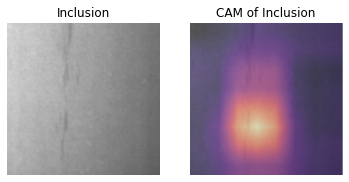

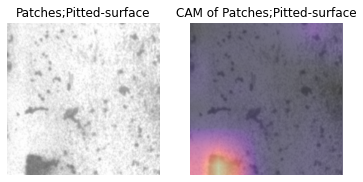

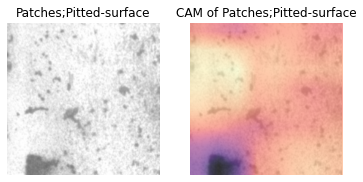

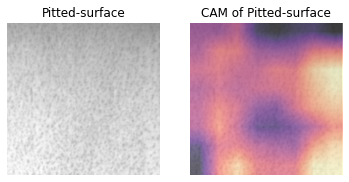

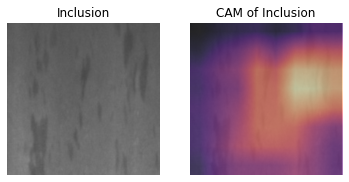

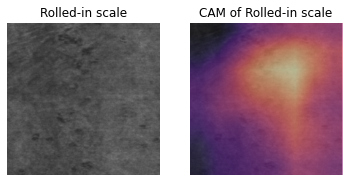

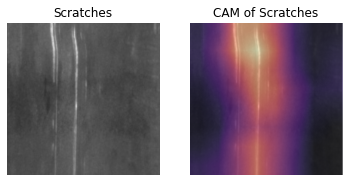

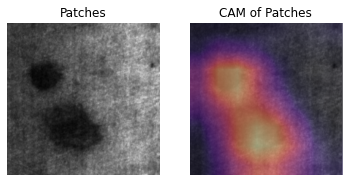

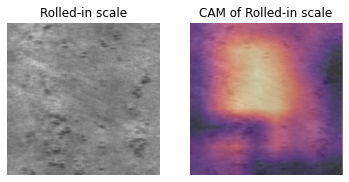

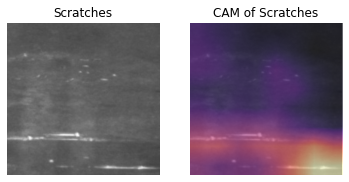

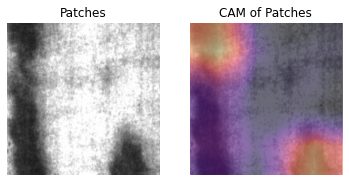

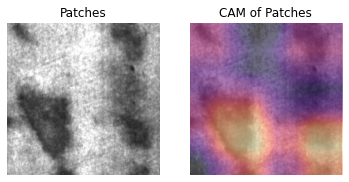

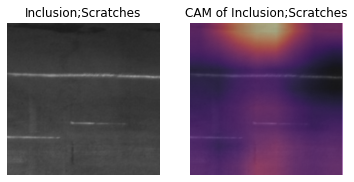

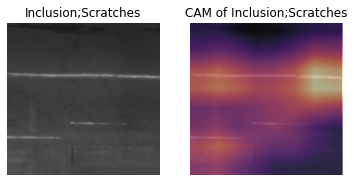

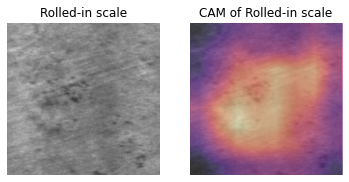

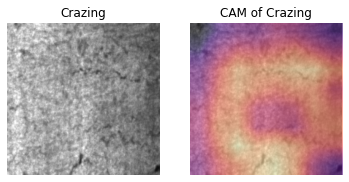

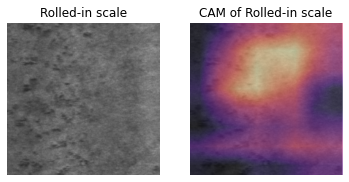

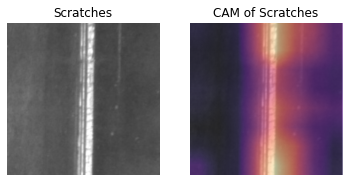

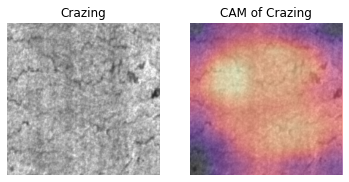

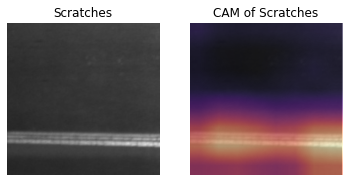

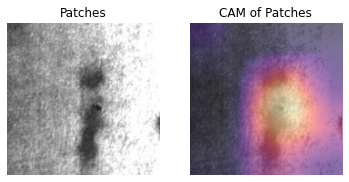

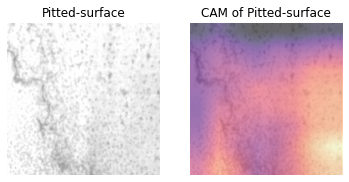

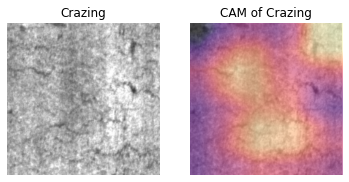

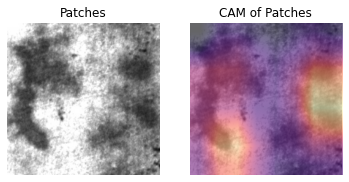

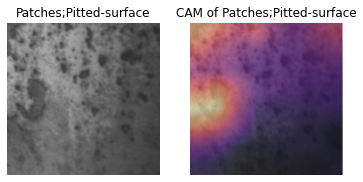

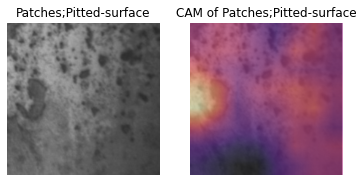

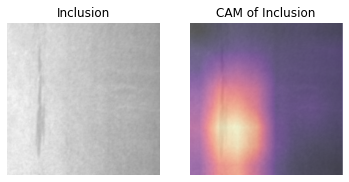

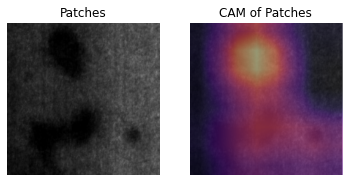

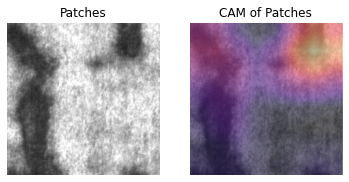

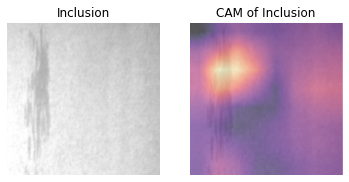

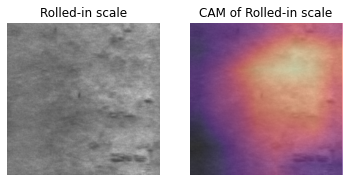

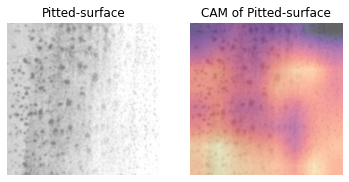

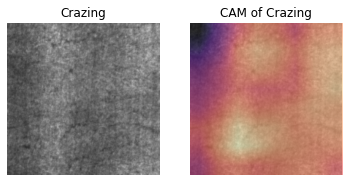

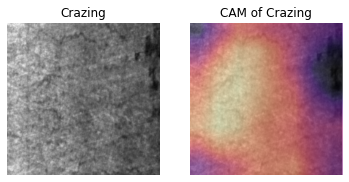

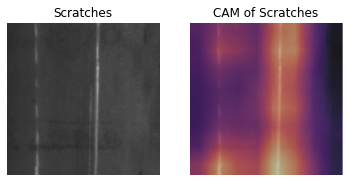

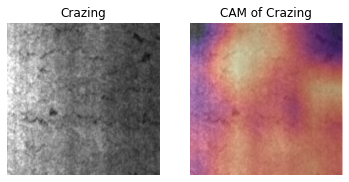

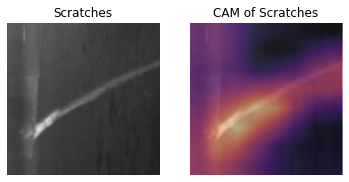

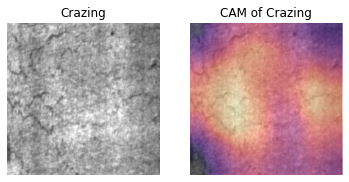

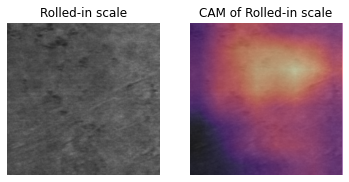

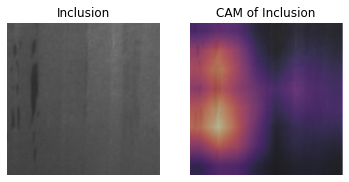

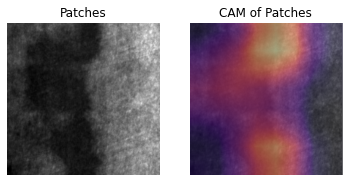

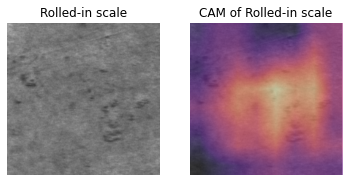

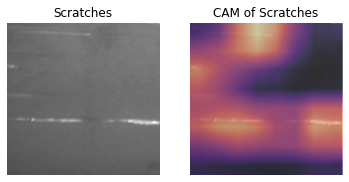

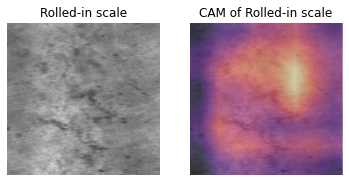

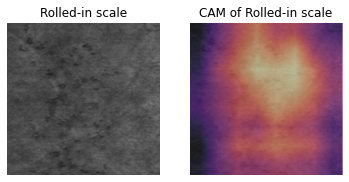

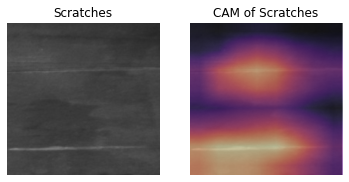

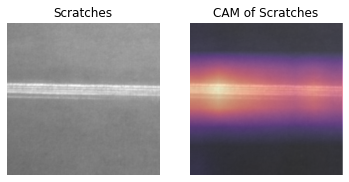

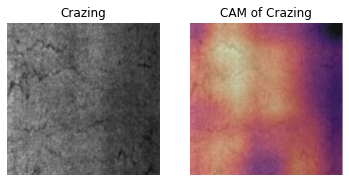

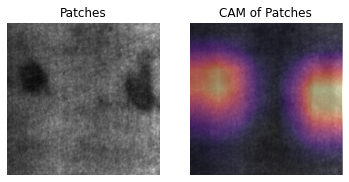

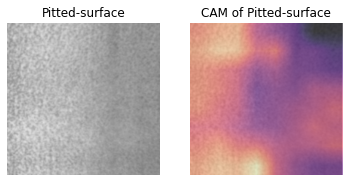

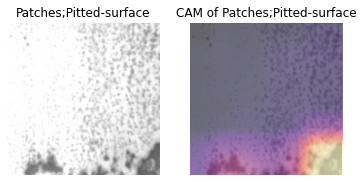

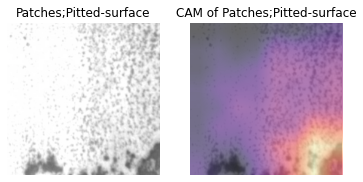

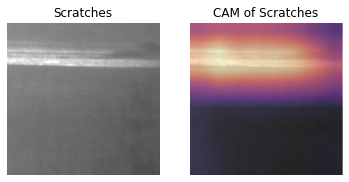

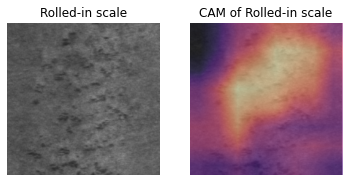

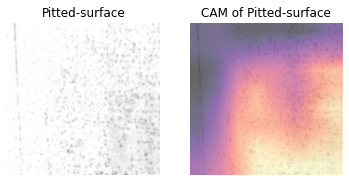

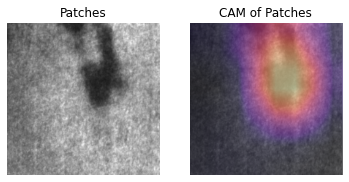

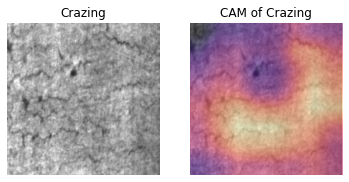

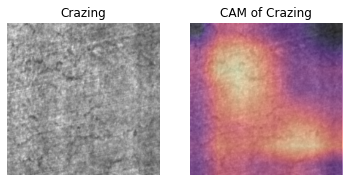

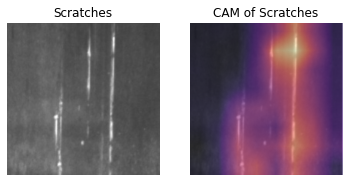

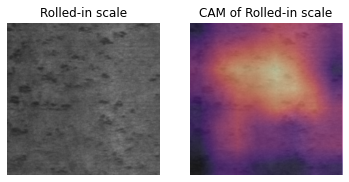

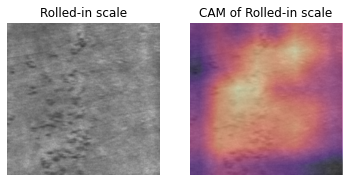

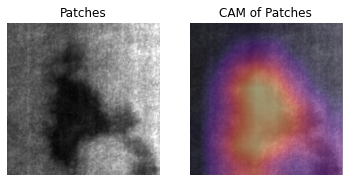

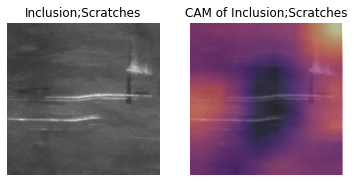

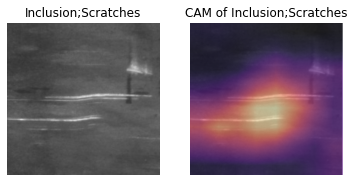

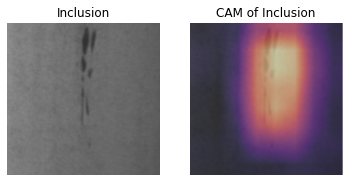

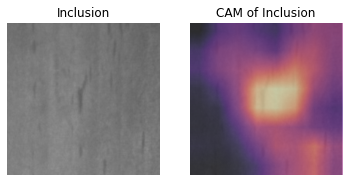

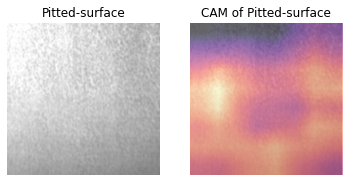

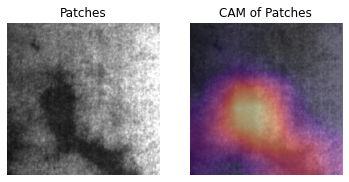

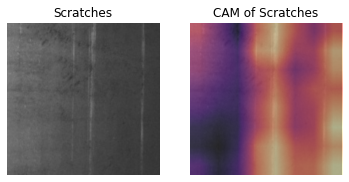

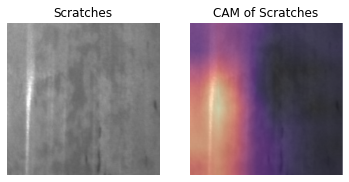

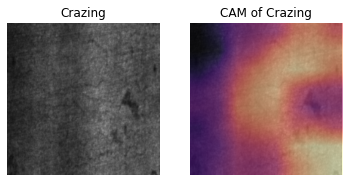

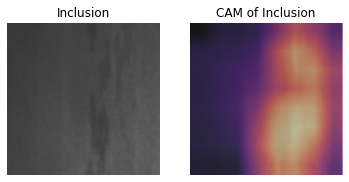

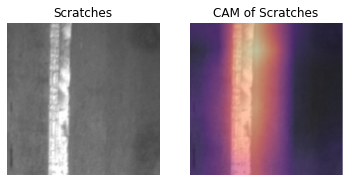

In [ ]:
from fastai.callbacks.hooks import *

def visualize_cnn_by_cam(learn, data_index):
    x, _y = learn.data.valid_ds[data_index]
    y = _y.data
    if not isinstance(y, (list, np.ndarray)): # single label -> one hot encoding
        y = np.eye(learn.data.valid_ds.c)[y]

    m = learn.model.eval()
    xb,_ = learn.data.one_item(x)
    xb_im = Image(learn.data.denorm(xb)[0])
    xb = xb.cuda()

    def hooked_backward(cat):
        with hook_output(m[0]) as hook_a: 
            with hook_output(m[0], grad=True) as hook_g:
                preds = m(xb)
                preds[0,int(cat)].backward()
        return hook_a,hook_g
    def show_heatmap(img, hm, label):
        _,axs = plt.subplots(1, 2)
        axs[0].set_title(label)
        img.show(axs[0])
        axs[1].set_title(f'CAM of {label}')
        img.show(axs[1])
        axs[1].imshow(hm, alpha=0.6, extent=(0,img.shape[1],img.shape[1],0),
                      interpolation='bilinear', cmap='magma');
        plt.show()

    for y_i in np.where(y > 0)[0]:
        hook_a,hook_g = hooked_backward(cat=y_i)
        acts = hook_a.stored[0].cpu()
        grad = hook_g.stored[0][0].cpu()
        grad_chan = grad.mean(1).mean(1)
        mult = (acts*grad_chan[...,None,None]).mean(0)
        show_heatmap(img=xb_im, hm=mult, label=str(learn.data.valid_ds.y[data_index]))

for idx in range(100):
    visualize_cnn_by_cam(learn, idx)
